# Sumário

- Configurações Iniciais
- Leitura
  - Média de Vendas
- Análise Exploratória
  - Sazonalidade com 7 dias
- Modelagem do Problema
  - Função `auto_arima`
  - Testes dos Parâmetros
  - Diagnóstico para `auto_arima`
  - Diagnóstico para Modelo Corrente
  - Predições para as observações de Validação
  - Comparações entre os Modelos Escolhidos

# Configurações Iniciais

In [31]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
import zipfile as zf # handle zip files

# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

# settings
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [15,7]
plt.rcParams['font.size'] = 15

In [2]:
# TIME SERIES
from pmdarima.arima import auto_arima, ARIMA
from pmdarima.utils.visualization import plot_pacf, plot_acf
from pmdarima.arima import ADFTest
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt, het_white
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.formula.api import ols
from statsmodels.tools.tools import add_constant
from statsmodels.compat import lzip
import statsmodels.api as sm
import scipy.stats as scs

# Leitura

In [3]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh', title=''):
    """ Gráficos ACF, PACF, QQPLOT e de Probabilidades. """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return


# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

In [4]:
# Loading files
unzip_fs = zf.ZipFile('competitive-data-science-predict-future-sales.zip', 'r')

aux = unzip_fs.open('sales_train.csv', 'r')
sales = pd.read_csv(aux)
aux.close()

# aux = unzip_fs.open('items.csv', 'r')
# item = pd.read_csv(aux)
# aux.close()


# Dont need to load
# aux = unzip_fs.open("item_categories.csv")
# item_cat=pd.read_csv(aux)
# aux.close()

# sub=pd.read_csv("sample_submission.csv")

# aux = unzip_fs.open("shops.csv")
# shops=pd.read_csv(aux)
# aux.close()

# aux = unzip_fs.open("test.csv")
# test=pd.read_csv(aux)
# aux.close()
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


Temos um conjunto de dados formados pelas seguintes colunas:
- `date` : data da movimentação de um produto em determinada filial;
- `date_block_num` : um índice do mês que em ocorreram as movimentações;
- `shop_id` : id da filial;
- `item_id` : id do item vendido;
- `item_price` : preço do item vendido (diferente para cada filial);
- `item_cnt_day` : quantidade de itens movimentados.

In [5]:
# formatando a coluna 'data' das vendas:
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


### Média

Nosso objetivo é modelar a média de itens vendidos por todas as filiais por dia, ou seja, a média de vendas de toda a companhia por dia, de modo que possamos predizer a venda média nos próximos 60 dias.

Para isso, agrupamos as somas das observações por data e id da loja e depois tiramos a média dos itens vendidos por dia.

Em seguida, separamos as últimas 60 observações para avaliarmos a predição do modelo final.

Obs de treino: 974 
Obs de teste: 60


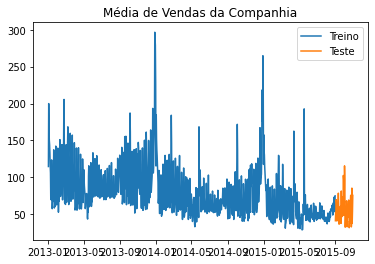

In [6]:
# agrupando todas as vendas da companhia
sales_shop = sales.groupby(by=['date',"shop_id"])[["item_cnt_day"]].sum().reset_index()
sales_mean = sales_shop.groupby(by=['date'])[["item_cnt_day"]].mean()

# separando em conjunto de treino e validação
teste = sales_mean.iloc[974:]
treino = sales_mean.iloc[:-60]
print(f'Obs de treino: {treino.shape[0]} \nObs de teste: {teste.shape[0]}')

plt.plot(treino, label='Treino')
plt.plot(teste, label="Teste")
plt.title('Média de Vendas da Companhia')
plt.legend()
plt.show()

# Análise Exploratória

Com base na existência de tendência e sazonalidade, podemos adotar dois tipos de modelos:

Aditivo:
$$
Z_{t} = S_{t} + T_{t} + Y_{t}
$$

Multiplicativo:
$$
Z_{t} = S_{t} T_{t} Y_{t}
$$

In [7]:
def decompose(series, period, model = 'multiplicative'):
    """Function to decompose the series in tree components:
    1- trend; 2- seasonality; 3- noise
    return: (decompose_object, noise_component)
    """
    resm = sm.tsa.seasonal_decompose(series.values,period=period,model=model)
    #plt.figure(figsize=(16,12))
    #print('Modelo Aditivo')
    fig = resm.plot()
    fig.show()

    # salva resíduos
    residuos = pd.DataFrame(resm.resid)
    residuos = residuos.dropna()[0].to_numpy()

    return resm, residuos

# para remover tendencia
def difference(dataset, interval=1):
    """ Function for differentiation: z(t) - z(t-inteval)
    return: differentiated series (length minus `interval`)
    """
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


## Investigação das Diferenciações

A seguir os gráficos de autocorrelação "normal" e parcial para a nossa série em diversas situações, isto é, vamos diferenciar a série afim de verificar a presença de sazonalidade e raízes unitárias.

Començando com a série normal, sem diferenciação.

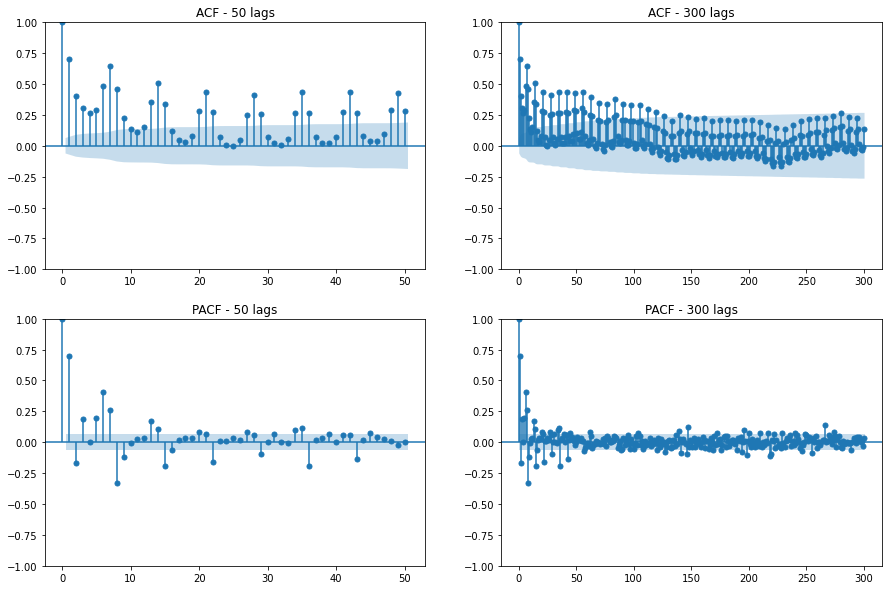

In [8]:
fig = plt.figure(figsize=(15, 10))
ax_1 = plt.subplot2grid((2,2), (0, 0))
ax_2 = plt.subplot2grid((2,2), (0, 1))
ax_3 = plt.subplot2grid((2,2), (1, 0))
ax_4 = plt.subplot2grid((2,2), (1, 1))
smt.graphics.plot_acf(treino.values, lags=50, ax=ax_1, alpha=0.05)
smt.graphics.plot_acf(treino.values, lags=300, ax=ax_2, alpha=0.05)
smt.graphics.plot_pacf(treino.values, lags=50, ax=ax_3, alpha=0.05)
smt.graphics.plot_pacf(treino.values, lags=300, ax=ax_4, alpha=0.05)
ax_1.set_title('ACF - 50 lags')
ax_2.set_title('ACF - 300 lags')
ax_3.set_title('PACF - 50 lags')
ax_4.set_title('PACF - 300 lags')
plt.show()

Vemos principalmente uma tendência cíclica nos gráficos, mas aparentemente as correlaões tendem a zero.

Prosseguimos com a diferenciação em um nível.

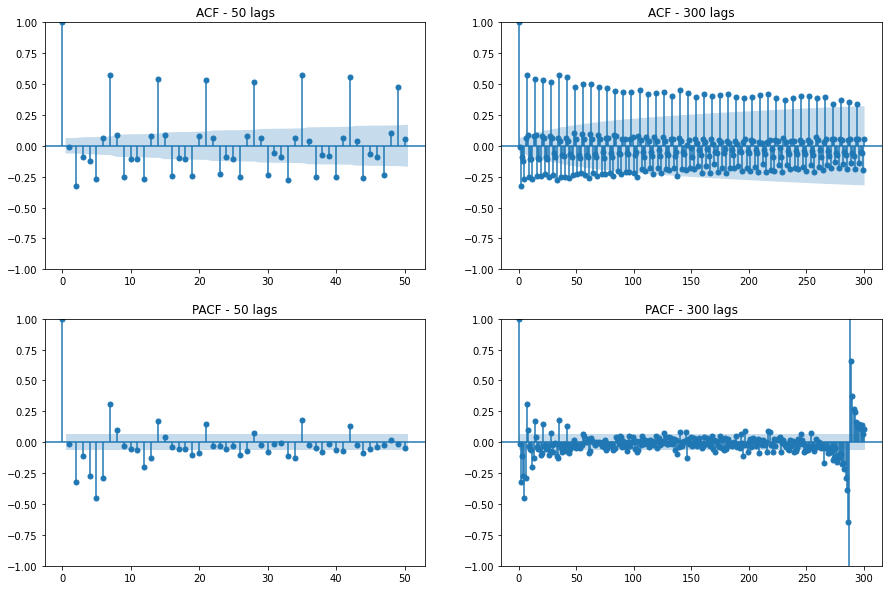

In [9]:
d1 = difference(treino.values, 1)

fig = plt.figure(figsize=(15, 10))
ax_1 = plt.subplot2grid((2,2), (0, 0))
ax_2 = plt.subplot2grid((2,2), (0, 1))
ax_3 = plt.subplot2grid((2,2), (1, 0))
ax_4 = plt.subplot2grid((2,2), (1, 1))
smt.graphics.plot_acf(d1, lags=50, ax=ax_1, alpha=0.05)
smt.graphics.plot_acf(d1, lags=300, ax=ax_2, alpha=0.05)
smt.graphics.plot_pacf(d1, lags=50, ax=ax_3, alpha=0.05)
smt.graphics.plot_pacf(d1, lags=300, ax=ax_4, alpha=0.05)
ax_1.set_title('ACF - 50 lags')
ax_2.set_title('ACF - 300 lags')
ax_3.set_title('PACF - 50 lags')
ax_4.set_title('PACF - 300 lags')
plt.show()

A diferenciação aparenta ter "ajustado" o gráfico ACF, agora ele de fato tende a zero, mas ainda vemos uma repetição cíclica.

Vamos tentar agora a diferenciação em 7 passos.

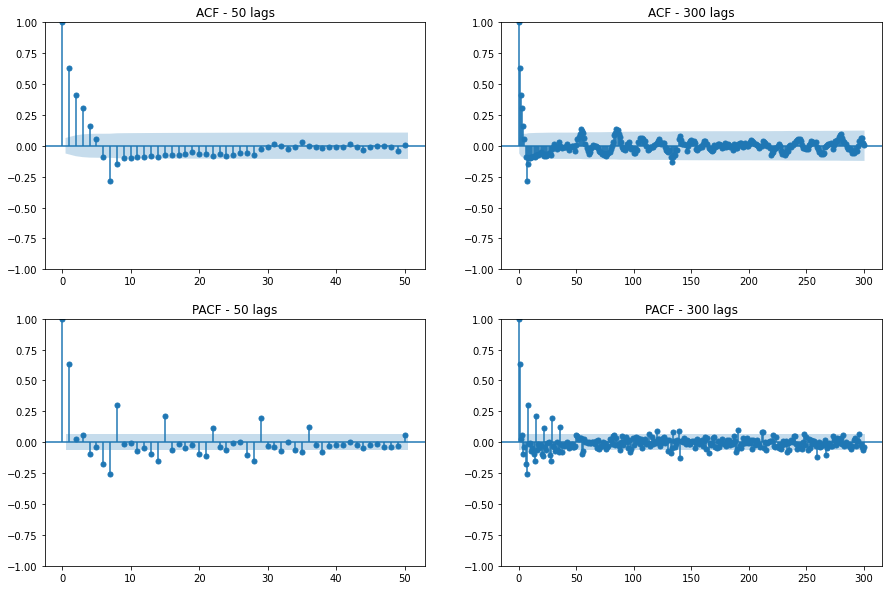

In [10]:
d7 = difference(treino.values, 7)

fig = plt.figure(figsize=(15, 10))
ax_1 = plt.subplot2grid((2,2), (0, 0))
ax_2 = plt.subplot2grid((2,2), (0, 1))
ax_3 = plt.subplot2grid((2,2), (1, 0))
ax_4 = plt.subplot2grid((2,2), (1, 1))
smt.graphics.plot_acf(d7, lags=50, ax=ax_1, alpha=0.05)
smt.graphics.plot_acf(d7, lags=300, ax=ax_2, alpha=0.05)
smt.graphics.plot_pacf(d7, lags=50, ax=ax_3, alpha=0.05)
smt.graphics.plot_pacf(d7, lags=300, ax=ax_4, alpha=0.05)
ax_1.set_title('ACF - 50 lags')
ax_2.set_title('ACF - 300 lags')
ax_3.set_title('PACF - 50 lags')
ax_4.set_title('PACF - 300 lags')
plt.show()

Como era esperado de um conjunto de vendas diárias, a diferenciação de 7 passos aparenta ter eliminado a repetição cíclica no gráfico ACF, e isto pode ser explicado pelo fato de que é natural que a cada sete dias os preços de vendas se repitam.

## Modelos com período de 7 dias

Primeiro, veremos a decomposição supondo uma relação aditiva entre as componentes.

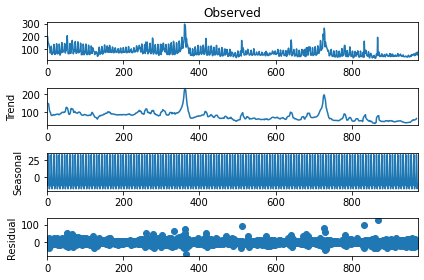

In [11]:
res_a = decompose(treino, period = 7, model = 'additive')

Para retirar essa estranha tendência, considere a diferenciação da série em um nível, e novamente a decomposição.

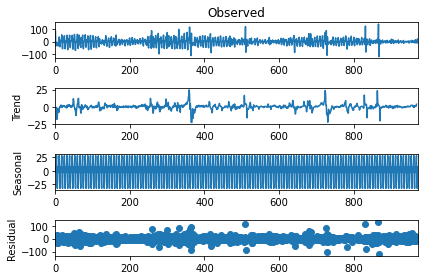

In [12]:
aux = decompose(difference(treino.to_numpy(), 1), period = 7, model = 'additive')

Temos uma considerável melhora nos resultados considerando a diferenciação.

Mas continuando, vamos supor uma relação multiplicativa entre as componentes agora.

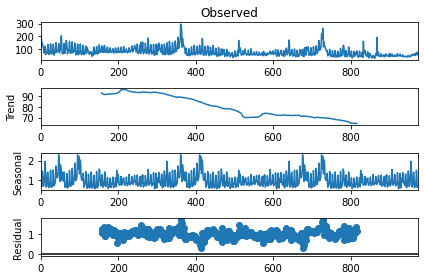

In [13]:
res_m = decompose(treino, period = 315)

Novamente, considere a diferenciação de um nível (também adicionamos uma constante, de 150, para que a função funcionasse, e não há nenhum problema, isso apenas deslocará a média para 150):

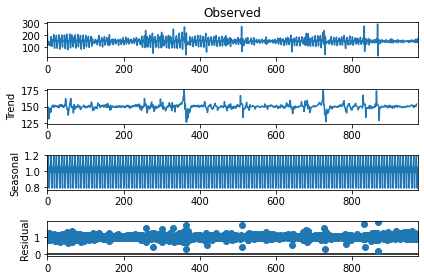

In [14]:
aux = decompose(difference(treino.to_numpy(), 1)+150, period = 7)

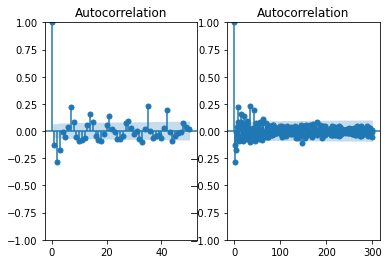

In [15]:
fig = plt.figure()
ax_1 = plt.subplot2grid((1,2), (0, 0))
ax_2 = plt.subplot2grid((1,2), (0, 1))
#plot_acf(aux[1], lags = 50, alpha=0.05, ax=ax_1)
#plot_acf(aux[1], lags = 300, alpha = 0.05, ax=ax_2)
smt.graphics.plot_acf(aux[1], lags=50, ax=ax_1, alpha=0.05)
smt.graphics.plot_acf(aux[1], lags=300, ax=ax_2, alpha=0.05)
plt.show()

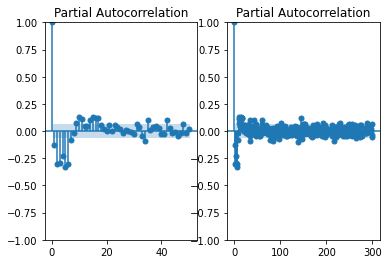

In [16]:
fig = plt.figure()
ax_1 = plt.subplot2grid((1,2), (0, 0))
ax_2 = plt.subplot2grid((1,2), (0, 1))
#plot_pacf(aux[1], lags = 50, alpha=0.05, ax=ax_1)
#plot_pacf(aux[1], lags = 300, alpha = 0.05, ax=ax_2)
smt.graphics.plot_pacf(aux[1], lags=50, ax=ax_1, alpha=0.05)
smt.graphics.plot_pacf(aux[1], lags=300, ax=ax_2, alpha=0.05)
plt.show()

E a partir do que vemos nos gráficos, vamos definir uma quantidade inicial de parâmetros para os dados.

# Modelagem do Problema

## Função `auto_arima`

Considerando a sazonalidade de 7 dias e os resultados da análise exploratória, utilizamos o autoarima para realizar a busca pelos melhores hiperparâmetros.

In [17]:
arima_model =  auto_arima(treino,start_p=0, d=None, start_q=0,
                          max_p=5, max_d=5, max_q=5, start_P=5,
                          D=None, start_Q=5, max_P=5, max_D=5,
                          max_Q=5, m=7, seasonal=True,
                          error_action='warn', trace = True,
                          supress_warnings=True, stepwise = True,
                          random_state=20, n_fits = 50 )


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(5,0,5)[7] intercept   : AIC=inf, Time=26.27 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=9161.346, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=8751.328, Time=0.59 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=8921.118, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=9159.349, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=9163.209, Time=0.21 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=8644.874, Time=1.31 sec
 ARIMA(1,1,0)(3,0,0)[7] intercept   : AIC=8594.888, Time=2.82 sec
 ARIMA(1,1,0)(4,0,0)[7] intercept   : AIC=8570.306, Time=3.62 sec
 ARIMA(1,1,0)(5,0,0)[7] intercept   : AIC=inf, Time=8.60 sec
 ARIMA(1,1,0)(4,0,1)[7] intercept   : AIC=8475.575, Time=6.59 sec
 ARIMA(1,1,0)(3,0,1)[7] intercept   : AIC=8473.924, Time=3.39 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=8471.924, Time=2.07 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=8472.309, Time=0.97 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=

Então, a seguir, o melhor modelo que a função escolheu.

In [18]:
print(arima_model.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                         y   No. Observations:                  974
Model:             SARIMAX(4, 1, 1)x(1, 0, [1, 2, 3], 7)   Log Likelihood               -4175.305
Date:                                   Tue, 13 Dec 2022   AIC                           8372.609
Time:                                           12:05:13   BIC                           8426.293
Sample:                                       01-01-2013   HQIC                          8393.040
                                            - 09-01-2015                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.001     -0.110      0.912    

## Testes do Parâmetros

Observando os p-valores, referentes ao teste de nulidade dos coeficientes, notamos que alguns coeficiente são estatisticamente iguais a zero. Assim, ajustaremos modelos mais simples levando em conta esses resultados.

In [19]:
# SARIMA (4,1,1) x (1,0,2)_7
print(ARIMA((4,1,1), seasonal_order=(1, 0, 2, 7) ).fit(treino).summary())

d:\Users\marcelo.silva\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Users\marcelo.silva\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  974
Model:             SARIMAX(4, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -4176.501
Date:                                Tue, 13 Dec 2022   AIC                           8373.002
Time:                                        12:05:18   BIC                           8421.805
Sample:                                    01-01-2013   HQIC                          8391.575
                                         - 09-01-2015                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.001     -0.115      0.908      -0.003       0.003
ar.

d:\Users\marcelo.silva\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
# SARIMA (3,1,1) x (1,0,3)_7
print(ARIMA((3,1,1), seasonal_order=(1, 0, 3, 7) ).fit(treino).summary())

d:\Users\marcelo.silva\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Users\marcelo.silva\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Users\marcelo.silva\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                         SARIMAX Results                                         
Dep. Variable:                                         y   No. Observations:                  974
Model:             SARIMAX(3, 1, 1)x(1, 0, [1, 2, 3], 7)   Log Likelihood               -4176.251
Date:                                   Tue, 13 Dec 2022   AIC                           8372.501
Time:                                           12:05:24   BIC                           8421.305
Sample:                                       01-01-2013   HQIC                          8391.075
                                            - 09-01-2015                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.001     -0.145      0.885    

In [21]:
# SARIMA (3,1,1) x (1,0,1)_7
print(ARIMA((3,1,1), seasonal_order=(1, 0, 1, 7) ).fit(treino).summary())

d:\Users\marcelo.silva\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Users\marcelo.silva\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  974
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -4182.013
Date:                           Tue, 13 Dec 2022   AIC                           8380.025
Time:                                   12:05:27   BIC                           8419.068
Sample:                               01-01-2013   HQIC                          8394.884
                                    - 09-01-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    2.22e-05      0.002      0.013      0.989      -0.003       0.003
ar.L1          0.6904      0.025     27.786

d:\Users\marcelo.silva\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Portanto, segundo os teste, definiremos o modelo corrente como SARIMA: $(3,1,1) \times (1,0,1)_7$.

In [22]:
working_model = ARIMA((3,1,1), seasonal_order=(1, 0, 1, 7) ).fit(treino)
print(working_model.summary())

d:\Users\marcelo.silva\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Users\marcelo.silva\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  974
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -4182.013
Date:                           Tue, 13 Dec 2022   AIC                           8380.025
Time:                                   12:05:30   BIC                           8419.068
Sample:                               01-01-2013   HQIC                          8394.884
                                    - 09-01-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    2.22e-05      0.002      0.013      0.989      -0.003       0.003
ar.L1          0.6904      0.025     27.786

d:\Users\marcelo.silva\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Diagnóstico para `auto_arima`

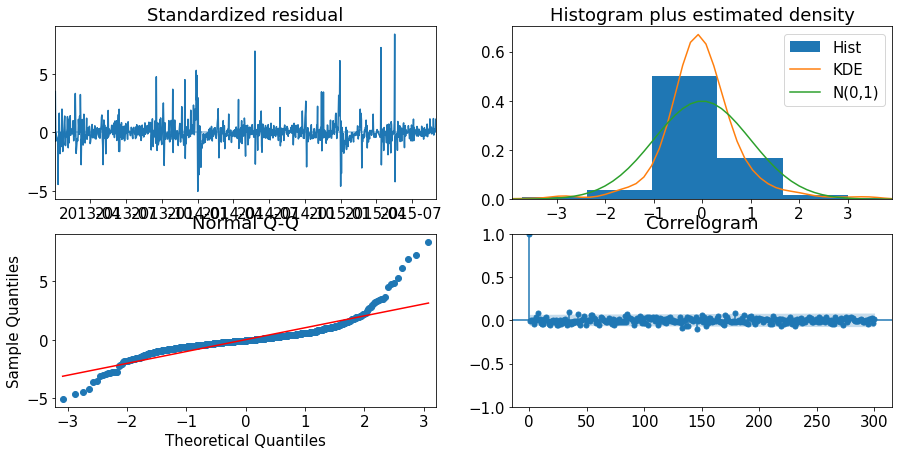

In [32]:
acf = arima_model.plot_diagnostics(lags = 300)

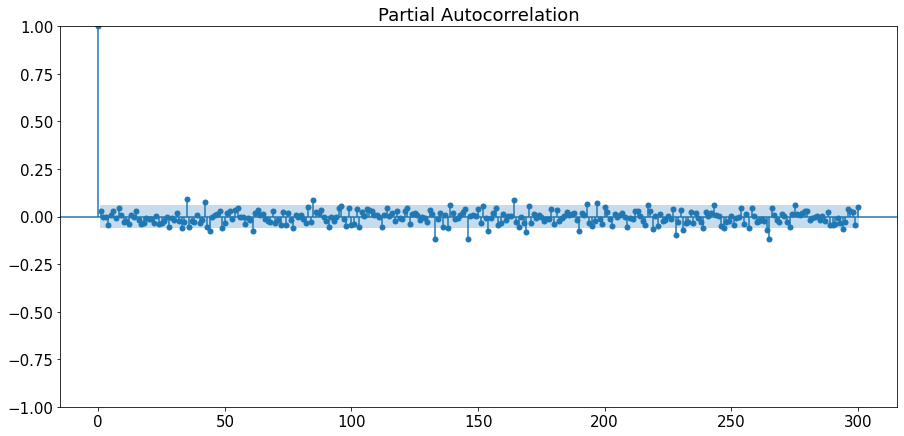

In [33]:
plot_pacf(arima_model.resid(), lags = 300, alpha = 0.05 )

## Diagnóstico para Modelo Corrente


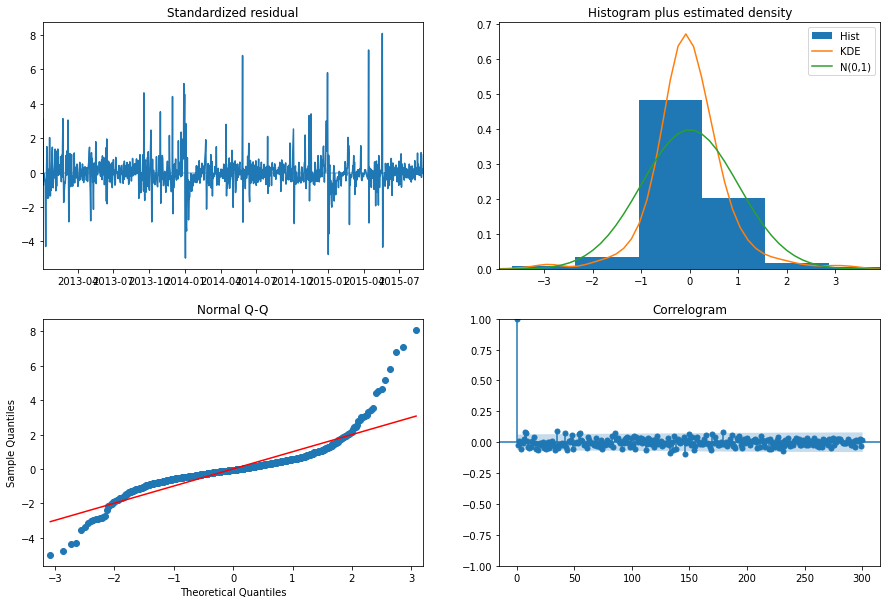

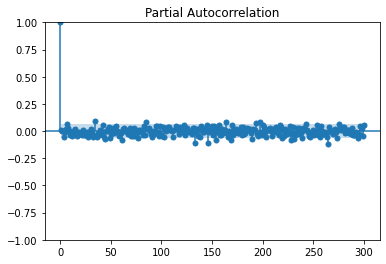

In [25]:
acf = working_model.plot_diagnostics(lags = 300,figsize=[15,10])
plot_pacf(working_model.resid(), lags = 300, alpha = 0.05)

## Predições para as observações de Validação

Por fim, realizamos a predição das observações retiradas do conjunto original para ambos os modelos ajustados.

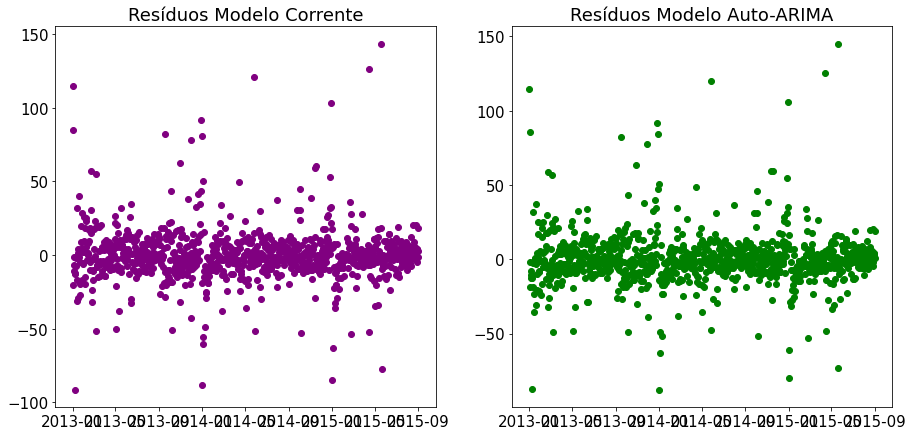

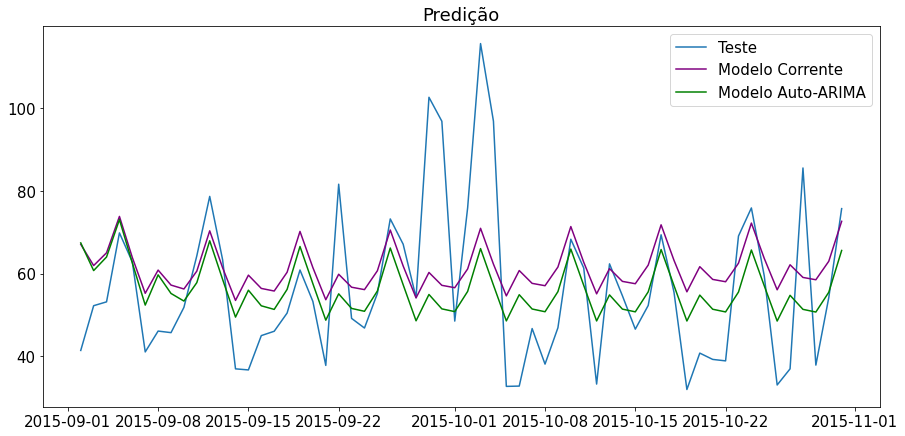

In [34]:
residuos = working_model.resid()
predicao = pd.DataFrame(working_model.predict(n_periods = 60)).set_index(teste.index)

res_oldmodel = arima_model.resid()
pred_oldmodel = pd.DataFrame(arima_model.predict(n_periods = 60)).set_index(teste.index)

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x=residuos.index, y=residuos, color='purple')
plt.title("Resíduos Modelo Corrente")
plt.subplot(1,2,2)
plt.scatter(x=res_oldmodel.index, y=res_oldmodel, color='green')
plt.title("Resíduos Modelo Auto-ARIMA")
plt.plot()

plt.figure()
# plt.plot(treino,label="Training")
plt.plot(teste, label="Teste")
plt.plot(predicao, label="Modelo Corrente", color='purple')
plt.plot(pred_oldmodel, label='Modelo Auto-ARIMA', color='green')
plt.title("Predição")
plt.legend()
plt.show()

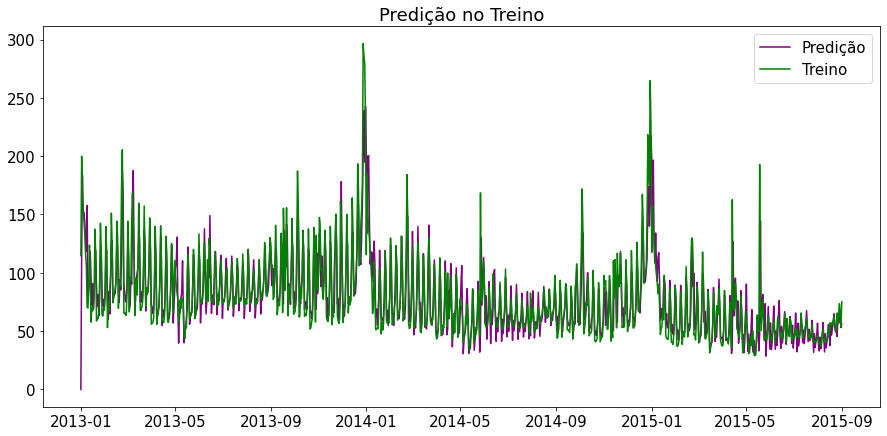

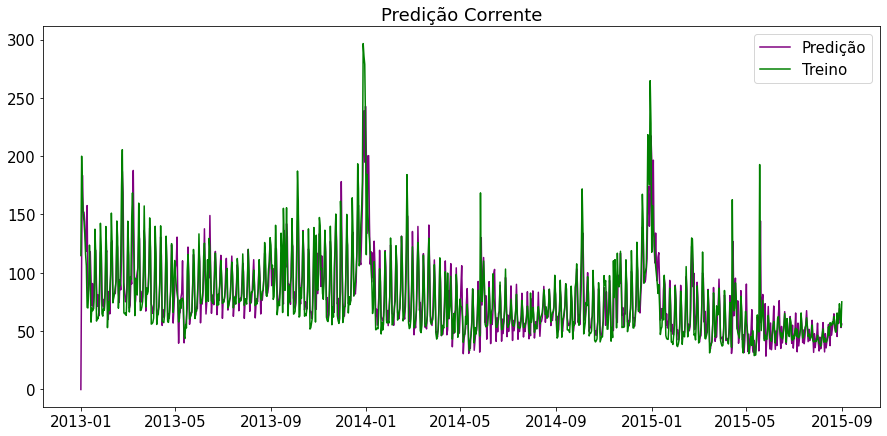

In [36]:
pred_insample_arima = arima_model.predict_in_sample()
pred_insample_corrente = working_model.predict_in_sample()

plt.figure()
plt.plot(pred_insample_arima, label="Predição", color='purple')
plt.plot(treino, label='Treino', color='green')
plt.title("Predição no Treino")
plt.legend()
plt.show()

plt.figure()
plt.plot(pred_insample_arima, label="Predição", color='purple')
plt.plot(treino, label='Treino', color='green')
plt.title("Predição Corrente")
plt.legend()
plt.show()

## Comparações entre os Modelos Escolhidos

In [28]:
## homocedasticidade breusch pagan e white

def homocedasticity_test(resid, type = "bp"):
    ## função do cara do medium, que eu acho que ta cheirando cola
    '''
    Retorna o p-valor do teste de homocedasticidade
    resid, array like: residuos do modelo
    type, str: o tipo de teste, bp para breusch-pagan, e wh para white
    return, float: p-valor do teste 
    '''

    resid_df = pd.DataFrame(resid.copy(), columns=['residuos'])
    resid_df["time"] = np.arange(len(resid_df))

    residual_model = ols(formula="residuos~time", data=resid_df).fit()

    if type == "bp":
        homo_test = het_breuschpagan(residual_model.resid, add_constant(resid_df["time"]))
    elif type == "wh":
        homo_test = het_white(residual_model.resid, add_constant(resid_df["time"]))

    return homo_test[3]


# minhas funções
def bp(resid):
    time = np.arange(len(resid))
    test = het_breuschpagan(resid, add_constant(time))

    return test[3]

bp(residuos)

def white(resid):
    time = np.arange(len(resid))
    test = het_white(resid, add_constant(time))

    return test[3]

def mse(y, y_hat):
    """Function to calculate the Mean Squared Error."""
    y = y.to_numpy()
    y_hat = y_hat.to_numpy()

    mse = sum((y-y_hat)**2)/len(y)

    return mse

In [29]:
# testes nos residuos:

## Normalidade - Shapiro-Wilk
pv_shapiro_arima = scs.shapiro(res_oldmodel).pvalue
pv_shapiro_corrente = scs.shapiro(residuos).pvalue

## Homocedasticidade - Goldfeld-Quandt
# het_goldfeldquandt null hypothesis that the variaces are not constant
pv_gold_corrente = het_goldfeldquandt(residuos,  treino.values, alternative= 'two-sided')[1].round(2)
pv_gold_arima = het_goldfeldquandt(res_oldmodel, treino.values, alternative= 'two-sided')[1].round(2)

## Homocedasticidade - Breusch Pagan
# het_breuschpagan null hypothesis that the variaces are not constant
pv_bp_corrente = bp(residuos).round(2)
pv_bp_arima = bp(res_oldmodel).round(2)

## Homocedasticidade - White
# het_white null hypothesis that the variaces are not constant
pv_wh_corrente = white(residuos).round(2)
pv_wh_arima = white(res_oldmodel).round(2)


## Raiz Unitaria - ADFuller
pv_corrente = adfuller(residuos)[1]
pv_arima = adfuller(res_oldmodel)[1]

In [30]:
## ordem correta
eqm_teste_corrente = mse(teste, predicao).round(0)
eqm_teste_oldmodel = mse(teste, pred_oldmodel).round(0)

eqm_treino_corrente = mse(treino, pd.DataFrame(pred_insample_corrente)).round(0)
eqm_treino_oldmodel = mse(treino, pd.DataFrame(pred_insample_arima)).round(0)

## ordem correta
df_testes = pd.DataFrame(np.array([[eqm_teste_corrente[0],eqm_treino_corrente[0],pv_shapiro_corrente,pv_gold_corrente,pv_corrente,pv_bp_corrente,pv_wh_corrente],
                      [eqm_teste_oldmodel[0],eqm_treino_oldmodel[0],pv_shapiro_arima, pv_gold_arima,pv_arima,pv_bp_arima,pv_wh_arima]]),
             columns= ['MSE Teste', 'MSE Treino', 'Shapiro', 'Goldfeld', 'ADFuller',"Breusch Pagan","White"],
             index = ['Modelo Corrente', 'Modelo Auto-ARIMA'])

df_testes

,MSE Teste,MSE Treino,Shapiro,Goldfeld,ADFuller,Breusch Pagan,White
Modelo Corrente,293.0,336.0,2.763066e-33,0.14,1.695841e-17,0.47,0.55
Modelo Auto-ARIMA,273.0,330.0,1.467974e-33,0.12,0.000000e+00,0.47,0.53


Assim, ambos os modelos satisfazem as suposições de estacionariedade e normalidade dos resíduos, pelo teste de raiz unitária de ADFuller e o de normalidade de Shapiro-Wilk. Contudo, nenhum dos dois  possui homogeneidade de variância pelo teste de Goldfeld. Por fim, o modelo com menor erro quadrático na previsão é o gerado pelo Auto-ARIMA.